# Monte Carlo Dropout (MCD) Quantification

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Conditional Variational Autoencoder (cVAE) in the design of connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

The aim of this file is it to analyse the MCD uncertainty and identify correlations to other metrics. Furhtermore, the computational efficiency of MCD simulations should be analyzed and the minimal number of needed MCD simulations for a robust uncertainty estimation quantified.

**Dependencies**: 
- `DNN.py`
- `Datareader.py`
- `Settings.py`
- `Plot_Functions.py`

## Setup

### Import

In [1]:
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans

from scipy.stats import norm
from scipy import stats

import torch
import torch.nn as nn
import torch.optim as optim

from Settings import Directory, Plotting_Parameters

import DataReader
importlib.reload(DataReader)
from DataReader import DataReader

import DNN
importlib.reload(DNN)
from DNN import DNN

import warnings
warnings.filterwarnings('ignore')

### Directory

In [2]:
directory = Directory()
plot_params = Plotting_Parameters()

model_name = "DNN_Model_Full_V2"

DATA_FILE = r"Data\Knee_Connection_Output_red.csv"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


### Load Data

In [3]:
datareader = DataReader()
df_full = datareader.load("Knee_Connection_Output_red.csv")

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
df_full_filtered.csv
Extended_Database.csv
Extended_Database_filtered_converted.csv
Extended_Database_FilterOn.csv
extended_profiles_filteron_iter_1.csv
extended_profiles_iter_1.csv
extended_profiles_iter_2.csv
extended_profiles_iter_3.csv
GAL_Generated_Data.csv
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
_OLD
Knee_Connection_Output_red.csv: (714385, 53)


### Load Model

In [4]:
model = DNN()
model = torch.load(MODEL_SAVE_FILE)
df = df_full.loc[model.data['data_indeces']]

for key, value in model.config.items():
    print(key, value)

print(model.data['data_reduction_factor'])

batch_size 256
epochs 3000
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Use larger network architecture and more features as training data. Also use Batch normalization
0


## Evaluate Model

In [5]:
y_pred, test_loss = model.evaluate()
y_true = model.y_test.numpy()
model.get_metrics(y_pred.numpy())

{'MSE': 3.0262208e-05,
 'RMSE': 0.0055011096,
 'MAE': 0.0037498153,
 'R2': 0.9979710623156279,
 'MCDMS': 0.004960395386702371,
 'MCDUS': 0.061298007002502264}

Get uncertainty of full data set. 

⚠️Attention⚠️: The returned and `mcd_std_unbiased` is unbiased (N-1). When calculating the standard deviation with `np.mean(data,axis=0)` the default is a biased (N) calulcation. Since the actual absolute values does not matter, but only the relative value, it does not matter which one is considered, but it should be consistant.

In [6]:
mcd_mean, mcd_std_unbiased, mcd_preds = model.mc_dropout_uncertainty(num_samples=1000, dropout_prob=0.1)

$$\sigma_{\text{MC}}=\frac{\sigma}{\mu}$$

In [7]:
uncertainty = mcd_std_unbiased / mcd_mean

In [24]:
import Settings
importlib.reload(Settings)
from Settings import Directory, Plotting_Parameters
plot_params = Plotting_Parameters()

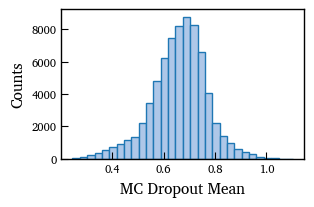

In [27]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(1/2))

_ = plt.hist(mcd_mean, 
             bins=30, 
             facecolor=plot_params.morecolors[1],
             edgecolor=plot_params.morecolors[0])
plt.xlabel('MC Dropout Mean')
plt.ylabel('Counts')

plt.show()

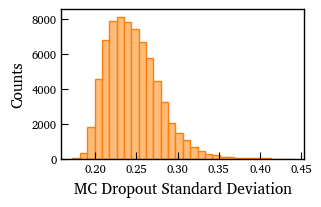

In [28]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(1/2))

_ = plt.hist(mcd_std_unbiased, 
             bins=30, 
             facecolor=plot_params.morecolors[3],
             edgecolor=plot_params.morecolors[2])
plt.xlabel('MC Dropout Standard Deviation')
plt.ylabel('Counts')

plt.show()

### Estimate Distribution Families

In [11]:
import scipy.stats as stats

def fit_and_select_distribution(data, distributions):
    results = []
    
    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        try:
            params = dist.fit(data)
            log_likelihood = np.sum(dist.logpdf(data, *params))
            k = len(params)
            aic = 2 * k - 2 * log_likelihood
            results.append((dist_name, aic))
        except Exception:
            continue
    
    results.sort(key=lambda x: x[1])
    return results


In [12]:
def fit_and_select_distribution(data, distributions):
    best_fits = []
    n = len(data)
    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        try:
            params = dist.fit(data)
            log_likelihood = np.sum(dist.logpdf(data, *params))
            k = len(params)
            aic = 2 * k - 2 * log_likelihood
            bic = k * np.log(n) - 2 * log_likelihood
            best_fits.append((dist_name, aic, bic))
        except Exception:
            continue
    best_fits.sort(key=lambda x: (x[1], x[2]))
    return best_fits

In [13]:
candidate_distributions = [
    'gamma', 'skewnorm', 'lognorm', 'weibull_min', 'beta',
    'gumbel_r', 'pareto', 'nakagami', 'expon', 'johnsonsu', 
    'triang', 'genextreme', 'norm'
]

mcd_mean_best_fits = fit_and_select_distribution(mcd_mean, candidate_distributions)
mcd_std_best_fits = fit_and_select_distribution(mcd_std_unbiased, candidate_distributions)
uncertainty_best_fits = fit_and_select_distribution(uncertainty, candidate_distributions)

print("Best fit distributions for MCD Mean:")
for dist_name, aic, bic in mcd_mean_best_fits:
    print(f"{dist_name}: AIC = {aic:.2f}, BIC = {bic:.2f}")

print("\nBest fit distributions for MCD Std:")
for dist_name, aic, bic in mcd_std_best_fits:
    print(f"{dist_name}: AIC = {aic:.2f}, BIC = {bic:.2f}")

print("\nBest fit distributions for Uncertainty:")
for dist_name, aic, bic in uncertainty_best_fits:
    print(f"{dist_name}: AIC = {aic:.2f}, BIC = {bic:.2f}")

Best fit distributions for MCD Mean:
johnsonsu: AIC = -119987.01, BIC = -119950.30
skewnorm: AIC = -118546.67, BIC = -118519.14
beta: AIC = -118013.95, BIC = -117977.25
weibull_min: AIC = -117391.75, BIC = -117364.22
norm: AIC = -116819.11, BIC = -116800.75
lognorm: AIC = -116618.50, BIC = -116590.97
nakagami: AIC = -116600.26, BIC = -116572.73
gamma: AIC = -115050.19, BIC = -115022.66
genextreme: AIC = -112588.51, BIC = -112560.98
gumbel_r: AIC = -94360.08, BIC = -94341.73
triang: AIC = -86228.23, BIC = -86200.71
expon: AIC = 16990.15, BIC = 17008.51
pareto: AIC = 17011.94, BIC = 17039.47

Best fit distributions for MCD Std:
beta: AIC = -300826.74, BIC = -300790.03
gamma: AIC = -300815.93, BIC = -300788.40
skewnorm: AIC = -300574.41, BIC = -300546.88
lognorm: AIC = -300500.87, BIC = -300473.34
johnsonsu: AIC = -300482.39, BIC = -300445.69
genextreme: AIC = -300318.54, BIC = -300291.01
gumbel_r: AIC = -300058.66, BIC = -300040.31
nakagami: AIC = -299500.70, BIC = -299473.17
weibull_min

In [14]:
dist_names_map = {
    'gamma': 'Gamma',
    'skewnorm': 'Skew-Normal',
    'lognorm': 'Log-Normal',
    'weibull_min': 'Weibull (Min)',
    'beta': 'Beta',
    'gumbel_r': 'Gumbel (Right)',
    'pareto': 'Pareto',
    'nakagami': 'Nakagami',
    'expon': 'Exponential',
    'johnsonsu': 'Johnson SU',
    'triang': 'Triangular',
    'genextreme': 'Generalized Extreme',
    'norm': 'Normal'
}

In [15]:
def to_aic_dict(best_fits):
    return {dist_names_map[dist]: int(aic) for dist, aic, _ in best_fits}

summary = pd.DataFrame({
    'MCD Mean': pd.Series(to_aic_dict(mcd_mean_best_fits)),
    'MCD Std': pd.Series(to_aic_dict(mcd_std_best_fits)),
    'Uncertainty': pd.Series(to_aic_dict(uncertainty_best_fits))
})

summary = summary.reindex(sorted(summary.index))
print(summary)

                     MCD Mean  MCD Std  Uncertainty
Beta                  -118013  -300826      -265250
Exponential             16990  -230598      -194299
Gamma                 -115050  -300815      -266677
Generalized Extreme   -112588  -300318      -285634
Gumbel (Right)         -94360  -300058      -278003
Johnson SU            -119987  -300482      -289857
Log-Normal            -116618  -300500      -279341
Nakagami              -116600  -299500      -244021
Normal                -116819  -292619      -218717
Pareto                  17011  -230578      -194299
Skew-Normal           -118546  -300574      -260283
Triangular             -86228  -256662      -111913
Weibull (Min)         -117391  -297749      -242226


In [16]:
summary

,MCD Mean,MCD Std,Uncertainty
Beta,-118013,-300826,-265250
Exponential,16990,-230598,-194299
Gamma,-115050,-300815,-266677
Generalized Extreme,-112588,-300318,-285634
Gumbel (Right),-94360,-300058,-278003
Johnson SU,-119987,-300482,-289857
Log-Normal,-116618,-300500,-279341
Nakagami,-116600,-299500,-244021
Normal,-116819,-292619,-218717
Pareto,17011,-230578,-194299


In [17]:
from scipy.stats import gamma, johnsonsu

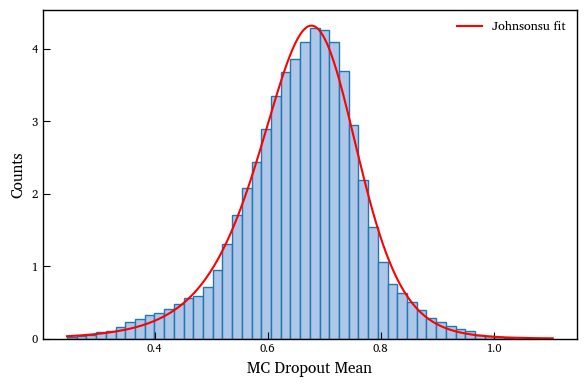

In [18]:
fig, ax = plt.subplots(figsize=(6,4))

x = np.linspace(min(mcd_mean), max(mcd_mean), 500)

mcd_mean_params = johnsonsu.fit(mcd_mean)
mcd_mean_pdf = johnsonsu.pdf(x, *mcd_mean_params)

_ = plt.hist(mcd_mean, 
             bins=50, 
             density=True,
             facecolor=plot_params.morecolors[1],
             edgecolor=plot_params.morecolors[0])

plt.plot(x, mcd_mean_pdf, 'r-', label='Johnsonsu fit')

plt.xlabel('MC Dropout Mean')
plt.ylabel('Counts')

plt.legend()
plt.tight_layout()
plt.show()

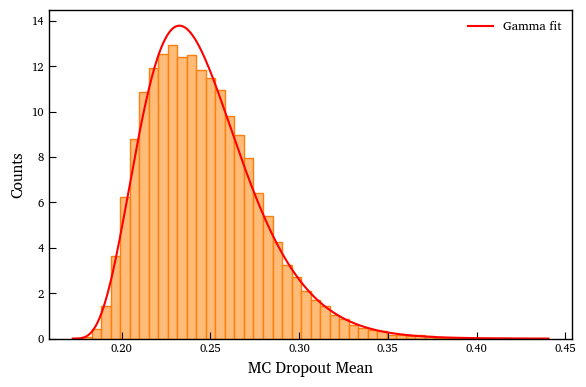

In [19]:
ffig, ax = plt.subplots(figsize=(6,4))

x = np.linspace(min(mcd_std_unbiased), max(mcd_std_unbiased), 500)

mcd_std_params = gamma.fit(mcd_std_unbiased)
mcd_std_pdf = gamma.pdf(x, *mcd_std_params)

_ = plt.hist(mcd_std_unbiased, 
             bins=50, 
             density=True,
             facecolor=plot_params.morecolors[3],
             edgecolor=plot_params.morecolors[2])

plt.plot(x, mcd_std_pdf, 'r-', label='Gamma fit')

plt.xlabel('MC Dropout Mean')
plt.ylabel('Counts')

plt.legend()
plt.tight_layout()
plt.show()

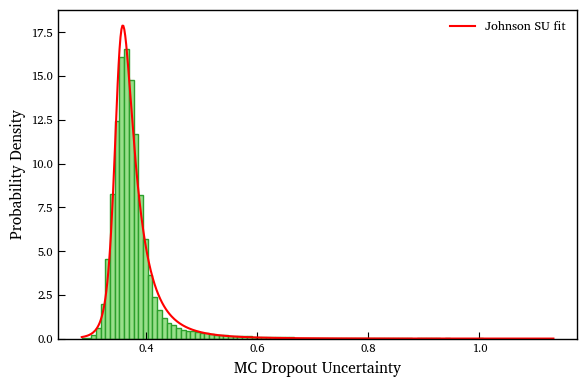

In [30]:
ffig, ax = plt.subplots(figsize=(6,4))

x = np.linspace(min(uncertainty), max(uncertainty), 500)

mcd_uncertainty_params = johnsonsu.fit(uncertainty)
mcd_uncertainty_pdf = johnsonsu.pdf(x, *mcd_uncertainty_params)

_ = plt.hist(uncertainty, 
             bins=100, 
             density=True,
             facecolor=plot_params.morecolors[5],
             edgecolor=plot_params.morecolors[4])

plt.plot(x, mcd_uncertainty_pdf, 'r-', label='Johnson SU fit')

plt.xlabel('MC Dropout Uncertainty')
plt.ylabel('Probability Density')

plt.legend()
plt.tight_layout()
plt.show()


$$
f(x) = \frac{\delta}{\sqrt{2\pi} \sqrt{(x - \xi)^2 + \lambda^2}} \exp\left( -\frac{1}{2} \left[ \gamma + \delta \cdot \sinh^{-1}\left( \frac{x - \xi}{\lambda} \right) \right]^2 \right)
$$


𝛾
γ: shape

𝛿
δ: shape

𝜉
ξ: location

𝜆
λ: scale

Finance: Modeling asset returns or income distributions where skew and kurtosis matter.

Hydrology & Meteorology: Rainfall, flood magnitudes, or wind speeds with skewed behavior.

Biostatistics: Physiological measurements that aren't normally distributed.

Reliability Engineering: Modeling life data with non-symmetric failure distributions.

Machine Learning & Simulation: As a flexible parametric input when standard distributions (normal, gamma, etc.) underperform.

Use central limit theorem:

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>n</mi><mo>≥</mo><msup><mrow><mo fence="true">(</mo><mfrac><mrow><msub><mi>z</mi><mrow><mn>1</mn><mo>−</mo><mi>α</mi><mi mathvariant="normal">/</mi><mn>2</mn></mrow></msub><mo>⋅</mo><mi>σ</mi></mrow><mrow><mi>p</mi><mo>⋅</mo><mi>μ</mi></mrow></mfrac><mo fence="true">)</mo></mrow><mn>2</mn></msup></mrow><annotation encoding="application/x-tex">n \ge \left( \frac{z_{1 - \alpha/2} \cdot \sigma}{p \cdot \mu} \right)^2</annotation></semantics></math>

In [31]:
mcd_uncertainty_params

(-0.9004417710721797,
 1.0787503913053944,
 0.3479570222829158,
 0.020007834770595707)

In [32]:
from scipy.stats import norm

In [34]:
a, b, loc, scale = mcd_uncertainty_params
mu, var = johnsonsu.stats(a, b, loc=loc, scale=scale, moments='mv')
sigma = var**0.5

accepted_error = 0.05
confidence_level = 0.99
z = norm.ppf(1-(1-confidence_level)/2)

n_required = (z * sigma / (accepted_error * mu))**2
print(f"Required sample size for ±{accepted_error*100:.1f}% error at 99% confidence: {int(np.ceil(n_required))}")


Required sample size for ±5.0% error at 99% confidence: 39


### Effect of MC Simulation Number

In [35]:
df_reduced = df_full.sample(10_000).copy()

In [36]:
simulations_tests = [5,10,15,20,50,100,200,500,750,1000]

In [37]:
uncertainty_progression = np.zeros((len(df_reduced), len(simulations_tests)))

for n_simulations in simulations_tests:
    print(n_simulations)
    mcd_mean, mcd_std_unbiased, mcd_preds = model.mc_dropout_uncertainty(
        df_input = df_reduced,
        num_samples=n_simulations, 
        dropout_prob=0.1)
    uncertainty = mcd_std_unbiased / mcd_mean

    uncertainty_progression[:, simulations_tests.index(n_simulations)] = uncertainty.flatten()

5
10
15
20
50
100
200
500
750
1000


Progression of uncertainties with increasing sample size:

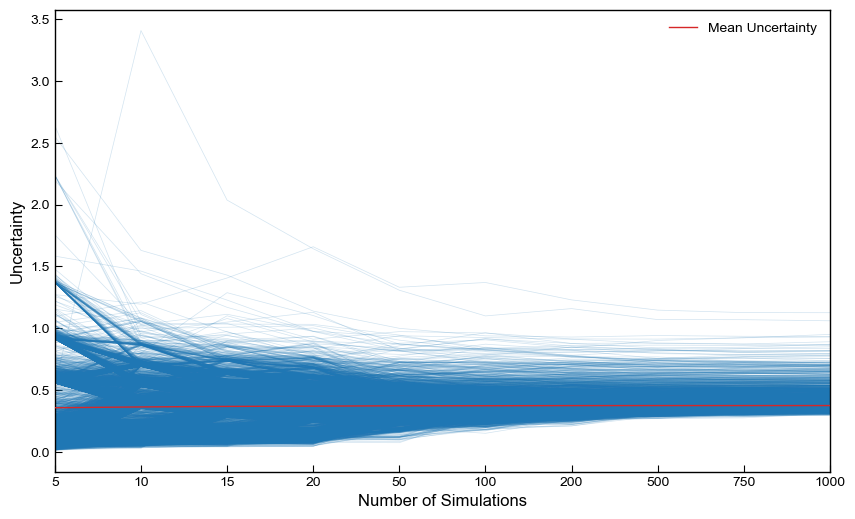

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(df_reduced)):
    plt.plot(uncertainty_progression[i],
             linewidth=0.5,
             alpha=0.2,
             c=plot_params.colors[0]
    )

plt.plot(np.mean(uncertainty_progression, axis=0),
         linewidth=1,
         c=plot_params.colors[3],
         label="Mean Uncertainty",
         zorder=10
    )

plt.legend()

plt.xlabel("Number of Simulations")
plt.ylabel("Uncertainty")

plt.xticks(range(len(simulations_tests)), simulations_tests)

plt.xlim([0, len(simulations_tests)-1])

plt.show()

Relative progression of uncertainties with increasing sample size.

In [38]:
final_uncertainty = uncertainty_progression[:, -1].reshape(-1, 1)
deviation_from_final = uncertainty_progression / final_uncertainty

accepted_deviation = 0.05

ratio_of_accepted = np.array([
    np.count_nonzero((deviation_from_final[:, i] >= 1 - accepted_deviation) & 
                     (deviation_from_final[:, i] <= 1 + accepted_deviation)) / len(df_reduced)
    for i in range(len(simulations_tests))
])

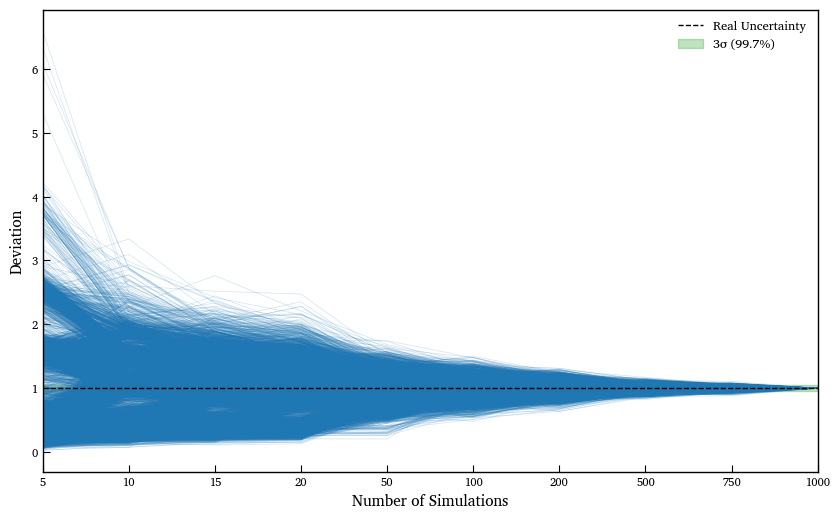

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(df_reduced)):
    plt.plot(deviation_from_final[i],
             linewidth=0.5,
             alpha=0.2,
             c=plot_params.colors[0]
    )

plt.axhline(y=1, color='k', linestyle='--', linewidth=1, label="Real Uncertainty")

plt.axhspan(1-accepted_deviation, 1+accepted_deviation, 
            alpha=0.3, 
            color=plot_params.colors[2], 
            label='3σ (99.7%)', zorder=0)

plt.legend()

plt.xlabel("Number of Simulations")
plt.ylabel("Deviation")

plt.xticks(range(len(simulations_tests)), simulations_tests)

plt.xlim([0, len(simulations_tests)-1])

plt.show()

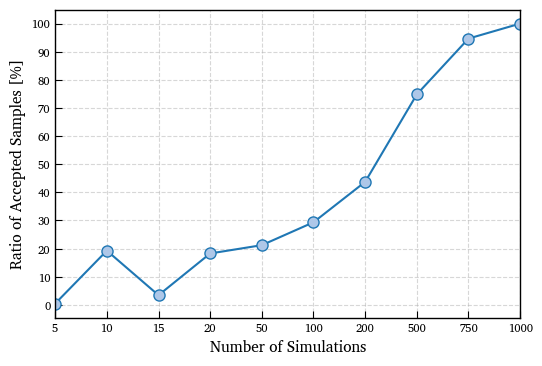

In [40]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(ratio_of_accepted, 
         marker='o', 
         markersize=8,
         markerfacecolor=plot_params.morecolors[1],
         markeredgecolor=plot_params.morecolors[0], 
         label='Accepted Ratio')

plt.xlabel('Number of Simulations')
plt.ylabel('Ratio of Accepted Samples [%]')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(0, len(simulations_tests)-1)
plt.xticks(range(len(simulations_tests)), simulations_tests)
plt.yticks(np.arange(0, 1.1, 0.1),np.arange(0,101,10))

plt.show()

### Visualize min sample size

In [41]:
mcd_mean, mcd_std_unbiased, mcd_preds = model.mc_dropout_uncertainty(
    df_input = df_reduced,
    num_samples=int(n_required), 
    dropout_prob=0.1)
uncertainty = mcd_std_unbiased / mcd_mean

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


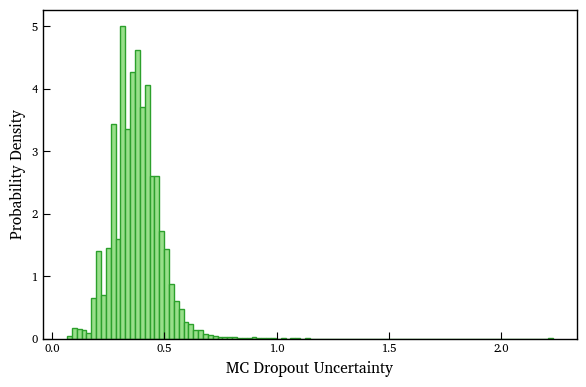

In [42]:
fig, ax = plt.subplots(figsize=(6,4))

#x = np.linspace(min(uncertainty), max(uncertainty), 500)

#mcd_uncertainty_params = johnsonsu.fit(uncertainty)
#mcd_uncertainty_pdf = johnsonsu.pdf(x, *mcd_uncertainty_params)

_ = plt.hist(uncertainty, 
             bins=100, 
             density=True,
             facecolor=plot_params.morecolors[5],
             edgecolor=plot_params.morecolors[4])

#plt.plot(x, mcd_uncertainty_pdf, 'r-', label='Johnson SU fit')

plt.xlabel('MC Dropout Uncertainty')
plt.ylabel('Probability Density')

plt.legend()
plt.tight_layout()
plt.show()

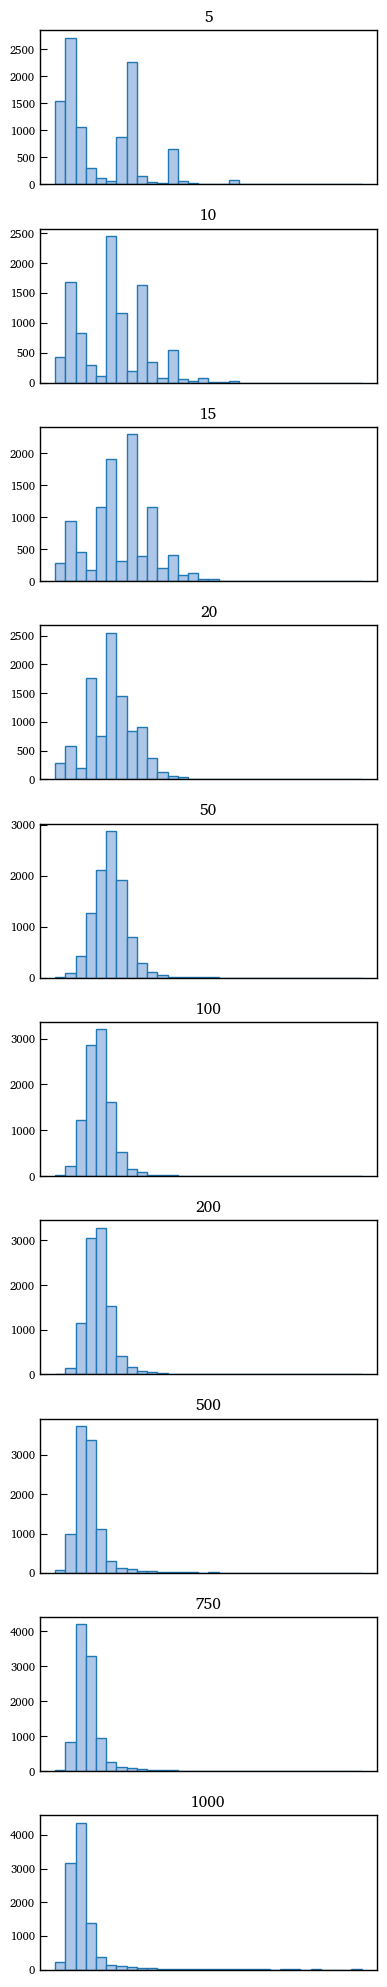

In [43]:
fig, axs = plt.subplots(uncertainty_progression.shape[1],1,figsize=(4,2*uncertainty_progression.shape[1]))

for i in range(uncertainty_progression.shape[1]):
    axs[i].hist(uncertainty_progression[:,i], 
             bins=30, 
             facecolor=plot_params.morecolors[1],
             edgecolor=plot_params.morecolors[0])
    axs[i].set_xticks([])
    axs[i].set_title(simulations_tests[i])
    
plt.tight_layout()
plt.show()

In [67]:
top_p_percent = 0.05
top_n_samples = int(len(df_reduced) * top_p_percent)
top_samples = np.zeros((uncertainty_progression.shape[1],top_n_samples))
p_identical = np.zeros(uncertainty_progression.shape[1]-1)
for i,uncertainty in enumerate(uncertainty_progression.T):
    rank = np.argsort(uncertainty)

    top_samples[i] = rank[-top_n_samples:]

for i in range(uncertainty_progression.shape[1]-1):
    p_identical[i] = np.isin(top_samples[i], top_samples[-1]).sum() / top_n_samples

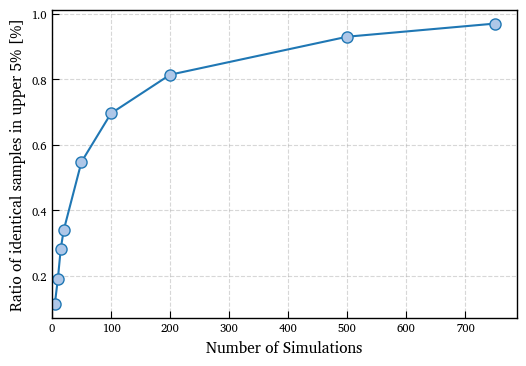

In [75]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(simulations_tests[:-1],p_identical,
         color=plot_params.colors[0],
         marker='o',
         markerfacecolor=plot_params.morecolors[1],
         markeredgecolor=plot_params.morecolors[0],
         markersize=8,
         label='Identical Samples Ratio')

plt.xlabel('Number of Simulations')
plt.ylabel('Ratio of identical samples in upper 5% [%]')
plt.xlim(0,None)

plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [60]:
def estimate_required_samples(model, df_input, accepted_deviation=0.05, target_ratio=0.99, final_samples=1000, max_samples=1000, step=10):
    print("Computing reference uncertainty with", final_samples, "samples...")
    mcd_mean_ref, mcd_std_ref, _ = model.mc_dropout_uncertainty(
        df_input=df_input,
        num_samples=final_samples,
        dropout_prob=0.1
    )
    uncertainty_ref = mcd_std_ref / mcd_mean_ref

    sample_sizes = list(range(step, max_samples + 1, step))
    for n in sample_sizes:
        mcd_mean, mcd_std, _ = model.mc_dropout_uncertainty(
            df_input=df_input,
            num_samples=n,
            dropout_prob=0.1
        )
        uncertainty_est = mcd_std / mcd_mean
        deviation = np.abs(uncertainty_est / uncertainty_ref - 1)

        ratio_within_error = np.mean(deviation <= accepted_deviation)

        print(f"Samples: {n}, Ratio within ±{accepted_deviation*100:.0f}%: {ratio_within_error:.3f}")

        if ratio_within_error >= target_ratio:
            print(f"\n✅ Minimum required samples: {n} (Ratio: {ratio_within_error:.3f})")
            return n

    print("\n❌ Did not reach target accuracy within max_samples")
    return None


In [82]:
estimate_required_samples(model, df_reduced, accepted_deviation=0.05, target_ratio=0.95, final_samples=2500, max_samples=1000, step=50)

Computing reference uncertainty with 2500 samples...
Samples: 50, Ratio within ±5%: 0.204
Samples: 100, Ratio within ±5%: 0.282
Samples: 150, Ratio within ±5%: 0.348
Samples: 200, Ratio within ±5%: 0.401
Samples: 250, Ratio within ±5%: 0.445
Samples: 300, Ratio within ±5%: 0.483
Samples: 350, Ratio within ±5%: 0.528
Samples: 400, Ratio within ±5%: 0.569
Samples: 450, Ratio within ±5%: 0.608
Samples: 500, Ratio within ±5%: 0.635
Samples: 550, Ratio within ±5%: 0.670
Samples: 600, Ratio within ±5%: 0.690
Samples: 650, Ratio within ±5%: 0.715
Samples: 700, Ratio within ±5%: 0.737
Samples: 750, Ratio within ±5%: 0.757
Samples: 800, Ratio within ±5%: 0.781
Samples: 850, Ratio within ±5%: 0.798
Samples: 900, Ratio within ±5%: 0.818
Samples: 950, Ratio within ±5%: 0.835
Samples: 1000, Ratio within ±5%: 0.854

❌ Did not reach target accuracy within max_samples
